# 개요  

이번 포스팅에서는 지난 [feature engineering 포스팅](https://yganalyst.github.io/project/dacon_bus_inout_2/)에 이어서 여러가지 머신러닝 알고리즘을 적용해서, 최종 산출물을 내보기로 한다.  
(아직 미완성)  
  
   
   

# Modeling  

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings(action='ignore')

import numpy as np
import os 

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import ParameterGrid, StratifiedKFold, KFold

from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz
from graphviz import Source
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import xgboost

In [2]:
os.chdir(r"D:\Python\dacon_bus_inout\result\\")
print("path: "+ os.getcwd())
print(os.listdir())

path: D:\Python\dacon_bus_inout\result
['regression.dot', 'result_interval.csv', 'result_interval_5_120.csv', 'rf_test_1.csv', 'test_r_set.csv', 'train_r_set.csv', 'xgb_test_1.csv']


In [3]:
# dir_ = ""
train = pd.read_csv("../result/train_r_set.csv", sep='|', encoding='cp949')
test = pd.read_csv("../result/test_r_set.csv", sep='|', encoding='cp949')
print("train :", len(train))
print("test :", len(test))

train : 415423
test : 228170


추가 작업을 시행  

- 요일변수 one-hot encoding, 월~일 dummy랑 공휴일만남김  

In [4]:
train[['mon','tue','wed','thr','fri','sat','sun']] = pd.get_dummies(train['dayofweek'])
test[['mon','tue','wed','thr','fri','sat','sun']] = pd.get_dummies(test['dayofweek'])

- 승객 유형 sum  

In [5]:
train['미성년자'] = train[['어린이','청소년']].sum(axis=1)
train['기타'] = train[['장애일반', '장애동반', '유공일반', '유공동반']].sum(axis=1)
test['미성년자'] = test[['어린이','청소년']].sum(axis=1)
test['기타'] = test[['장애일반', '장애동반', '유공일반', '유공동반']].sum(axis=1)

In [6]:
x_dummy_cols = [
                'mon', 'tue', 'wed', 'thr', 'fri', 'sat', 'sun', 'holiday',
                #'일반', '어린이', '청소년','경로', '장애일반', '장애동반', '유공일반', '유공동반',
                '일반', '미성년자','기타',
                'in_out_new', 
               ]
x_cols = [
          '6~7_ride', '7~8_ride', '8~9_ride','9~10_ride', '10~11_ride', '11~12_ride',
          '6~7_takeoff', '7~8_takeoff','8~9_takeoff', '9~10_takeoff', '10~11_takeoff','11~12_takeoff',
          #'ride_1','ride_2', 'takeoff_1', 'takeoff_2',
          'travel_time',
          #'all_cnt', 'rule_cnt',
          #'min_interval_m',
          'mean_interval_m',
          'loc_distance',
          '강수_mn', '강수_ev', '기온_mn', '기온_ev',
          '습도_mn', '습도_ev', '지면온도_mn', '지면온도_ev',
          '풍속_mn', '풍속_ev'
         ]
y_col = ['18~20_ride']

X_train = train[x_cols + x_dummy_cols]
y_train = train[y_col]
X_test = test[x_cols + x_dummy_cols]

  

# 1. Scaling  

- dummy변수들은 제외하고 스케일링(독립변수만, 표준화로)진행    

In [7]:
def scaler(df, opt='standard'):
    if opt=='standard':
        scale = StandardScaler()
    elif opt=='minmax':
        scale = StandardScaler()    
    scale.fit(df)
    return scale.transform(df)

In [8]:
X_train[x_cols] = scaler(X_train[x_cols], opt='standard')
X_test[x_cols] = scaler(X_test[x_cols], opt='standard')

  
  
  
# 2. Sampling method  

**계층적 k겹 샘플링(startified Kfold Sampling)**  
> 주로 분류문제에서 불균형 데이터에 대한 샘플링 방법으로, Random sampling보다 효율적  
> 타깃 레이블의 전체 대비 비율(분포?)을 유지해주면서 sampling해줌(회귀문제에선 아직 잘 모르겠다.)    

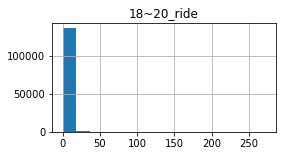

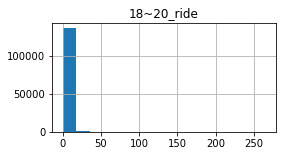

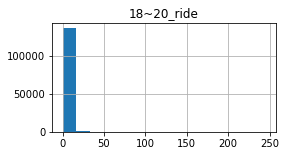

In [10]:
skfolds = StratifiedKFold(n_splits=3,shuffle=True, random_state=208)     # 계층적 k겹 표본추출
for train_index, test_index in skfolds.split(X_train, y_train):   
    y_train.loc[test_index].hist(bins=15, figsize=(4,2))

위와 같이 0~1이 대부분인 불균형 데이터에 대하여, 분포를 유지한채 3겹으로 샘플링 해주었다.  
단순 랜덤표본 추출보다는 검증단계에서 일반화의 오류에 빠지지 않을 수 있을 것 같다.  

In [11]:
kfolds = KFold(n_splits=10, shuffle=True, random_state=208)     # 기본 k겹
skfolds = StratifiedKFold(n_splits=10,shuffle=True, random_state=208)     # 계층적 k겹 표본추출


  
  
# 3. Model Selection  

이전에 공부했었던 모델을 바탕으로 적용해보려고 했다.  
CART알고리즘을 기본으로 하는 [Descision Tree](https://yganalyst.github.io/study/ML_chap5/)와 Tree의 앙상블 모델인 [Random Foreset](https://yganalyst.github.io/study/ML_chap6-3/), [xgboost](https://yganalyst.github.io/study/ML_chap6-4/#3-xgbosst)를 활용했다.  
자세한 내용은 이전에 포스팅했었던 위의 링크를 타고 가면 된다.  

## 3-1. Tree  

**Parameter**  

- `max_depth` : default는 None으로 최대 깊이까지 학습(과대적합 가능성이 크므로 제한 주기)  
- `min_samples_split` : 분할되기 위해 노드가 가져야하는 최소 샘플 수  
- `min_samples_leaf` : 리프 노드가 가져야할 최소 샘플 수  
- `min_weight_fraction_leaf` : min_samples_leaf와 같지만 가중치가 부여된 전체 샘플 수에서의 비율  
- `max_leaf_nodes` : 리프 노드의 최대 수  
- `max_features` : 각 노드에서 분할에 사용할 변수의 최대 수  

(예시)  

In [11]:
tree_reg = DecisionTreeRegressor(max_depth = 3,
                                random_state=208)
tree_reg.fit(X_train,y_train)

DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=208, splitter='best')

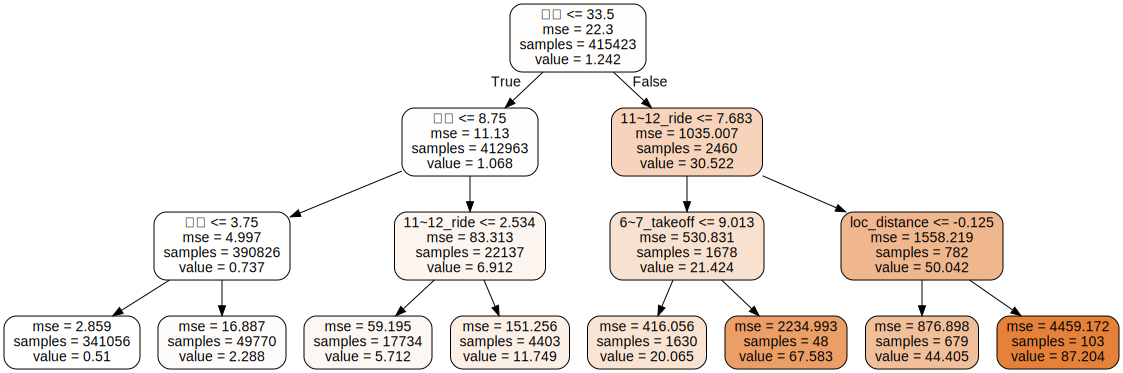

In [12]:
export_graphviz(tree_reg,                              # 모델
               out_file= "regression.dot",             # 저장경로 설정
               feature_names=X_train.columns,                   # 변수명
               rounded = True,                         # 시각화(둥근네모)
               filled = True)                          # 시각화(도형채우기)
Source.from_file("regression.dot")

**Cross validation**  

- 파라미터 조정 & 샘플링 방식 변경  
- 성능 별로  

In [13]:
tree_reg = DecisionTreeRegressor(
                                 max_features=7,
                                 min_samples_leaf=5,
                                 min_samples_split=10,
                                 random_state=208
                                )

for cv_ in [kfolds, skfolds, 10]:
    scores = cross_val_score(tree_reg, X_train, y_train, 
                             scoring = "neg_mean_squared_error",
                             cv=cv_)
    
    print("="*5 + type(cv_).__name__ + "="*5 )
    rmse_scores = np.sqrt(-scores)
    print("Scores :", rmse_scores)
    print("Mean_rmse : " + str(round(np.mean(rmse_scores))))
    print("std_rmse : " + str(round(rmse_scores.std(),6)))
    print("\n")

=====KFold=====
Scores : [4.05982928 3.87923825 3.51923216 3.70645787 3.79507228 3.74208049
 4.02201001 3.99998843 3.78494707 3.79464265]
Mean_rmse : 4.0
std_rmse : 0.15655


=====StratifiedKFold=====
Scores : [3.76005063 3.73618522 4.26605397 3.79848926 3.57092759 3.79810131
 3.78032787 3.66075359 3.90525961 3.5891629 ]
Mean_rmse : 4.0
std_rmse : 0.186775


=====int=====
Scores : [3.86960502 3.86039245 3.46305275 3.92941261 4.31557629 4.23666014
 3.26850242 4.46365827 3.45973618 3.34699524]
Mean_rmse : 4.0
std_rmse : 0.404305




  
## 3-2. ensemble - RandomForest  

- RandomForest는 배깅(복원추출방식)을 적용한 Tree의 앙상블 모델  
- Tree Parameter 그대로 갖고 있고, 몇개의 Tree를 쓸건지(n_estimators) 지정  

In [15]:
rf_reg = RandomForestRegressor(
                                n_estimators=50,
                                max_features=7,
                                min_samples_leaf=5,
                                min_samples_split=10,
                                n_jobs=4,
                                random_state=208
                              )


scores = cross_val_score(rf_reg, X_train, y_train, 
                         scoring = "neg_mean_squared_error",
                         cv=kfolds)

print("="*5 + type(cv_).__name__ + "="*5 )
rmse_scores = np.sqrt(-scores)
print("Scores :", rmse_scores)
print("Mean_rmse : " + str(round(np.mean(rmse_scores))))
print("std_rmse :", rmse_scores.std())
print("\n")

=====int=====
Scores : [3.42606352 3.12660157 2.8999335  3.065909   3.09069948 3.27700777
 3.13008307 3.30502241 3.18308162 2.82462897]
Mean_rmse : 3.0
std_rmse : 0.17160329885446585




In [23]:
rf_reg.fit(X_train, y_train)
sub_df = pd.read_csv('../data/submission_sample.csv')
sub_df['18~20_ride'] = rf_reg.predict(X_test)
sub_df.to_csv('rf_basic_1.csv', index = False)

  

## 3-3. ensemble - Xgboost  

CART알고리즘을 활용하는 결국 RandomForest의 부류인 부스팅 알고리즘  

- 이전 모델이 만든 잔여오차(residual error)에 새로운 모델을 학습(그래디언트 부스팅(Gradient Boosting)을 기반)
- (배깅은 개별 모델들의 예측값을 마지막에 집계만 함)  
- 1모델로 학습 -> 잔여오차로 2모델 학습 -> 잔여오차로 3모델 학습 ... (새로운 샘플이 들어왔을때 각 모델의 예측값의 sum)  

*[파라미터 설명 참고](https://blog.naver.com/PostView.nhn?blogId=gustn3964&logNo=221431714122&from=search&redirect=Log&widgetTypeCall=true&directAccess=false)  

In [24]:
st_sampling = StratifiedShuffleSplit(n_splits=1, test_size = 0.1, random_state= 42)

In [25]:
X_train_t, X_val = train_test_split(X_train, test_size = 0.2, random_state=208)
y_train_t, y_val = train_test_split(y_train, test_size = 0.2, random_state=208)

In [30]:
xgb_reg=xgboost.XGBRegressor(booster='gbtree', 
                             colsample_bylevel=0.9, 
                             colsample_bytree=0.8, 
                             gamma=0, 
                             max_depth=10, 
                             min_child_weight=3, 
                             n_estimators=250, 
                             nthread=4, 
                             objective='reg:linear', 
                             random_state=208)

xgb_reg.fit(X_train_t,y_train_t,
            eval_set=[(X_val,y_val)],
            eval_metric = 'rmse',
            early_stopping_rounds=100)

[16:35:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:4.77293
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:4.55417
[2]	validation_0-rmse:4.34637
[3]	validation_0-rmse:4.16387
[4]	validation_0-rmse:4.01638
[5]	validation_0-rmse:3.8933
[6]	validation_0-rmse:3.77621
[7]	validation_0-rmse:3.6645
[8]	validation_0-rmse:3.57037
[9]	validation_0-rmse:3.49774
[10]	validation_0-rmse:3.42933
[11]	validation_0-rmse:3.3694
[12]	validation_0-rmse:3.33157
[13]	validation_0-rmse:3.29737
[14]	validation_0-rmse:3.2623
[15]	validation_0-rmse:3.23265
[16]	validation_0-rmse:3.20905
[17]	validation_0-rmse:3.18137
[18]	validation_0-rmse:3.16354
[19]	validation_0-rmse:3.15061
[20]	validation_0-rmse:3.13233
[21]	validation_0-rmse:3.12256
[22]	validation_0-rmse:3.10839
[23]	validation_0-rmse:3.09571
[24]	validation_0-rmse:3.08567
[25]	vali

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.9,
             colsample_bynode=1, colsample_bytree=0.8, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=10, min_child_weight=3, missing=None, n_estimators=250,
             n_jobs=1, nthread=4, objective='reg:linear', random_state=208,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [34]:
sub_df = pd.read_csv('../data/submission_sample.csv')
sub_df['18~20_ride'] = xgb_reg.predict(X_test)
sub_df.to_csv('xgb_test_1.csv', index = False)

  
  
# 4. Parameter Tunning  

## 4-1. gridSearch - RandomForest  

In [ ]:
param_grid = [
    {'n_estimators': [200, 300, 400],
     'max_features': [5, 8],
     'min_samples_leaf':[1],
     'min_samples_split':[2]},  
    {'bootstrap': [False], # 비복원추출
     'n_estimators': [150, 200, 250],
     'max_features': [5, 8],
     'min_samples_leaf':[1],
     'min_samples_split':[2]}
  ]
skfolds = StratifiedKFold(n_splits=10, random_state=208)
rf_reg = RandomForestRegressor(random_state=208)
grid_search = GridSearchCV(rf_reg,
                           param_grid,
                           cv = skfolds,
                           n_jobs=4,
                           scoring='neg_mean_squared_error',
                           return_train_score=True,
                           verbose=2)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)